C:\Users\ayyar\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ayyar\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss = 0.8546, Val Loss = 0.3434
Epoch 2: Train Loss = 0.4550, Val Loss = 0.2798
Epoch 3: Train Loss = 0.3705, Val Loss = 0.1775
Epoch 4: Train Loss = 0.3095, Val Loss = 0.1482
Epoch 5: Train Loss = 0.2770, Val Loss = 0.2134
Epoch 6: Train Loss = 0.2335, Val Loss = 0.1992
Epoch 7: Train Loss = 0.1917, Val Loss = 0.3066
Epoch 8: Train Loss = 0.1736, Val Loss = 0.0651
Epoch 9: Train Loss = 0.1500, Val Loss = 0.0669
Epoch 10: Train Loss = 0.1367, Val Loss = 0.0898
Epoch 11: Train Loss = 0.1148, Val Loss = 0.0808
Epoch 12: Train Loss = 0.1053, Val Loss = 0.0380
Epoch 13: Train Loss = 0.0884, Val Loss = 0.0387
Epoch 14: Train Loss = 0.0803, Val Loss = 0.0381
Epoch 15: Train Loss = 0.0808, Val Loss = 0.0284
Epoch 16: Train Loss = 0.0660, Val Loss = 0.0470
Epoch 17: Train Loss = 0.0677, Val Loss = 0.0326
Epoch 18: Train Loss = 0.0564, Val Loss = 0.0368
Epoch 19: Train Loss = 0.0685, Val Loss = 0.0403
Epoch 20: Train Loss = 0.0696, Val Loss = 0.0669
Epoch 21: Train Loss = 0.0636

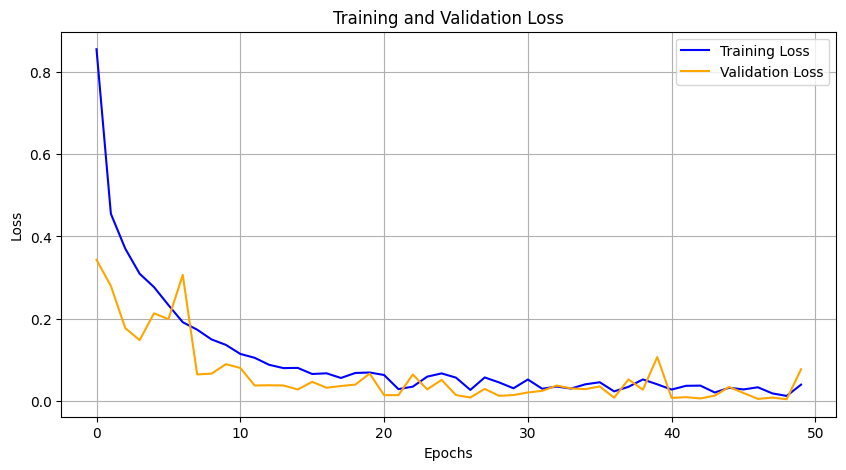


Classification Report:
              precision    recall  f1-score   support

          A+       0.99      0.98      0.99       565
          A-       0.96      0.95      0.95      1009
         AB+       0.99      0.97      0.98       708
         AB-       0.92      1.00      0.96       761
          B+       0.98      0.99      0.98       652
          B-       0.97      0.98      0.98       741
          O+       0.99      0.96      0.97       852
          O-       0.98      0.95      0.97       712

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



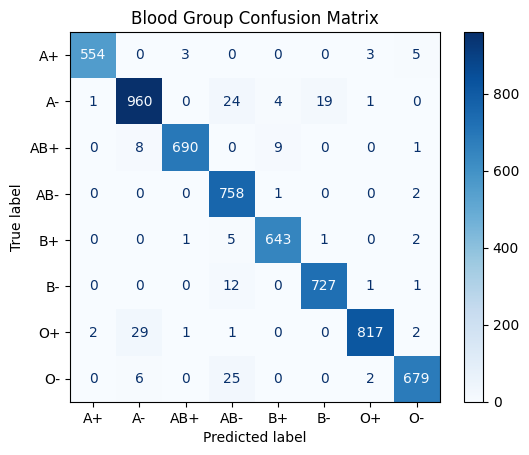

In [15]:
# ===============================
# Import Required Libraries
# ===============================
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import shufflenet_v2_x1_0
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize

# ===============================
# 1. Fingerprint Preprocessing & Feature Extraction
# ===============================
def extract_fingerprint_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (300, 300))
    img_eq = cv2.equalizeHist(img)
    thresh_val = threshold_otsu(img_eq)
    binary = img_eq > thresh_val
    skeleton = skeletonize(binary).astype(np.uint8)
    ridge_frequency = np.sum(skeleton) / skeleton.size * 100
    sobelx = cv2.Sobel(img_eq, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img_eq, cv2.CV_64F, 0, 1, ksize=5)
    orientation = np.arctan2(sobely, sobelx)
    orientation_std = np.std(orientation)

    if orientation_std < 0.5:
        fingerprint_type = "arch"
    elif orientation_std < 1.0:
        fingerprint_type = "loop"
    else:
        fingerprint_type = "whorl"

    return fingerprint_type, round(ridge_frequency, 2)

# ===============================
# 2. Rule-Based Predictions
# ===============================
def rule_based_diabetes(f_type, freq, gender, hand):
    score = 0
    if f_type in ['arch', 'whorl']: score += 1
    if freq < 12: score += 1
    if gender.lower() == 'female': score += 1
    if hand.lower() == 'left': score += 1
    return "Diabetic" if score >= 7 else "Non-Diabetic"

def rule_based_hypertension(f_type):
    return "Hypertensive" if f_type in ['whorl', 'loop'] else "Non-Hypertensive"

# ===============================
# 3. Data Transforms & Dataset
# ===============================
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder(root=r'C:\Users\ayyar\OneDrive\Desktop\FINGER_PRINT_BLOOD_GROUP\train', transform=transform)
val_dataset = datasets.ImageFolder(root=r'C:\Users\ayyar\OneDrive\Desktop\FINGER_PRINT_BLOOD_GROUP\test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# ===============================
# 4. ShuffleNet Model Setup
# ===============================
num_classes = len(train_dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = shufflenet_v2_x1_0(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ===============================
# 5. Training Loop
# ===============================
train_losses, val_losses = [], []

for epoch in range(50):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    

# ===============================
# 6. Plot Training and Validation Loss
# ===============================
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# ===============================
# 7. Evaluation
# ===============================
all_preds, all_true = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=train_dataset.classes))

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Blood Group Confusion Matrix")
plt.show()

# ===============================
# 8. Prediction Function
# ===============================
def predict_fingerprint(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return class_names[predicted.item()]

def display_image_with_prediction(image_path, prediction_text):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Prediction: {prediction_text}')
    plt.axis('off')
    plt.show()


Fingerprint Type: whorl, Ridge Frequency: 1.36
Predicted Blood Group: B+
Predicted Diabetes Status: Non-Diabetic
Predicted Hypertension Status: Hypertensive


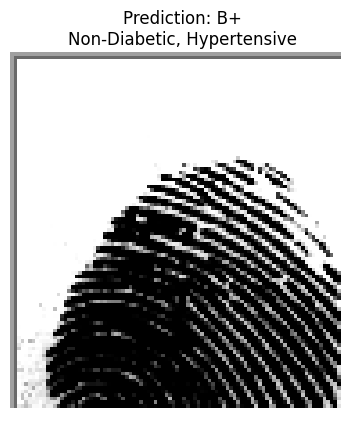

In [17]:
# ===============================
# 9. Example Usage
# ===============================
image_path=r'D:\My project\dataset_blood_group\B+\cluster_2_431.BMP'


print(f"Fingerprint Type: {fingerprint_type}, Ridge Frequency: {ridge_freq}")
fingerprint_type, ridge_freq = extract_fingerprint_features(image_path)
predicted_blood_group = predict_fingerprint(image_path, model, transform, train_dataset.classes)

gender = "female"
hand = "left"
diabetes = rule_based_diabetes(fingerprint_type, ridge_freq, gender, hand)
hypertension = rule_based_hypertension(fingerprint_type)

print(f"Predicted Blood Group: {predicted_blood_group}")
print(f"Predicted Diabetes Status: {diabetes}")
print(f"Predicted Hypertension Status: {hypertension}")

display_image_with_prediction(image_path, f"{predicted_blood_group}\n{diabetes}, {hypertension}")
